<a href="https://colab.research.google.com/github/gyyang/neurogym/blob/master/examples/demo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Exploring NeuroGym tasks

NeuroGym is a comprehensive toolkit that allows training any network model on many established neuroscience tasks using Reinforcement Learning techniques. It includes working memory tasks, value-based decision tasks and context-dependent perceptual categorization tasks.

In this notebook we first show how to install the relevant toolbox. 

We then show how to access the available tasks and their relevant information.

Finally we train an LSTM network on the Random Dots Motion task using the A2C algorithm [Mnih et al. 2016](https://arxiv.org/abs/1602.01783) implemented in the [stable-baselines3](https://stable-baselines3.readthedocs.io/en/master/) toolbox, and plot the results.

You can easily change the code to train a network on any other available task or using a different algorithm (e.g. ACER, PPO2).


### Installation on google colab

In [6]:
# Install gymnasium
! pip install gymnasium
# Install neurogym
! git clone https://github.com/gyyang/neurogym.git
%cd neurogym/
! pip install -e .
# Install stable-baselines3
! pip install stable-baselines3

UsageError: Line magic function `%tensorflow_version` not found.


### Explore tasks

In [1]:
import warnings
import gymnasium as gym
import neurogym as ngym
from neurogym.utils import info, plotting
warnings.filterwarnings('ignore')
info.all_tasks()

AntiReach-v0
Bandit-v0
ContextDecisionMaking-v0
DawTwoStep-v0
DelayComparison-v0
DelayMatchCategory-v0
DelayMatchSample-v0
DelayMatchSampleDistractor1D-v0
DelayPairedAssociation-v0
DualDelayMatchSample-v0
EconomicDecisionMaking-v0
GoNogo-v0
HierarchicalReasoning-v0
IntervalDiscrimination-v0
MotorTiming-v0
MultiSensoryIntegration-v0
Null-v0
OneTwoThreeGo-v0
PerceptualDecisionMaking-v0
PerceptualDecisionMakingDelayResponse-v0
PostDecisionWager-v0
ProbabilisticReasoning-v0
PulseDecisionMaking-v0
Reaching1D-v0
Reaching1DWithSelfDistraction-v0
ReachingDelayResponse-v0
ReadySetGo-v0
SingleContextDecisionMaking-v0
psychopy.RandomDotMotion-v0
psychopy.SpatialSuppressMotion-v0
psychopy.VisualSearch-v0


### Visualize a single task

<OrderEnforcing<PassiveEnvChecker<PerceptualDecisionMaking>>>


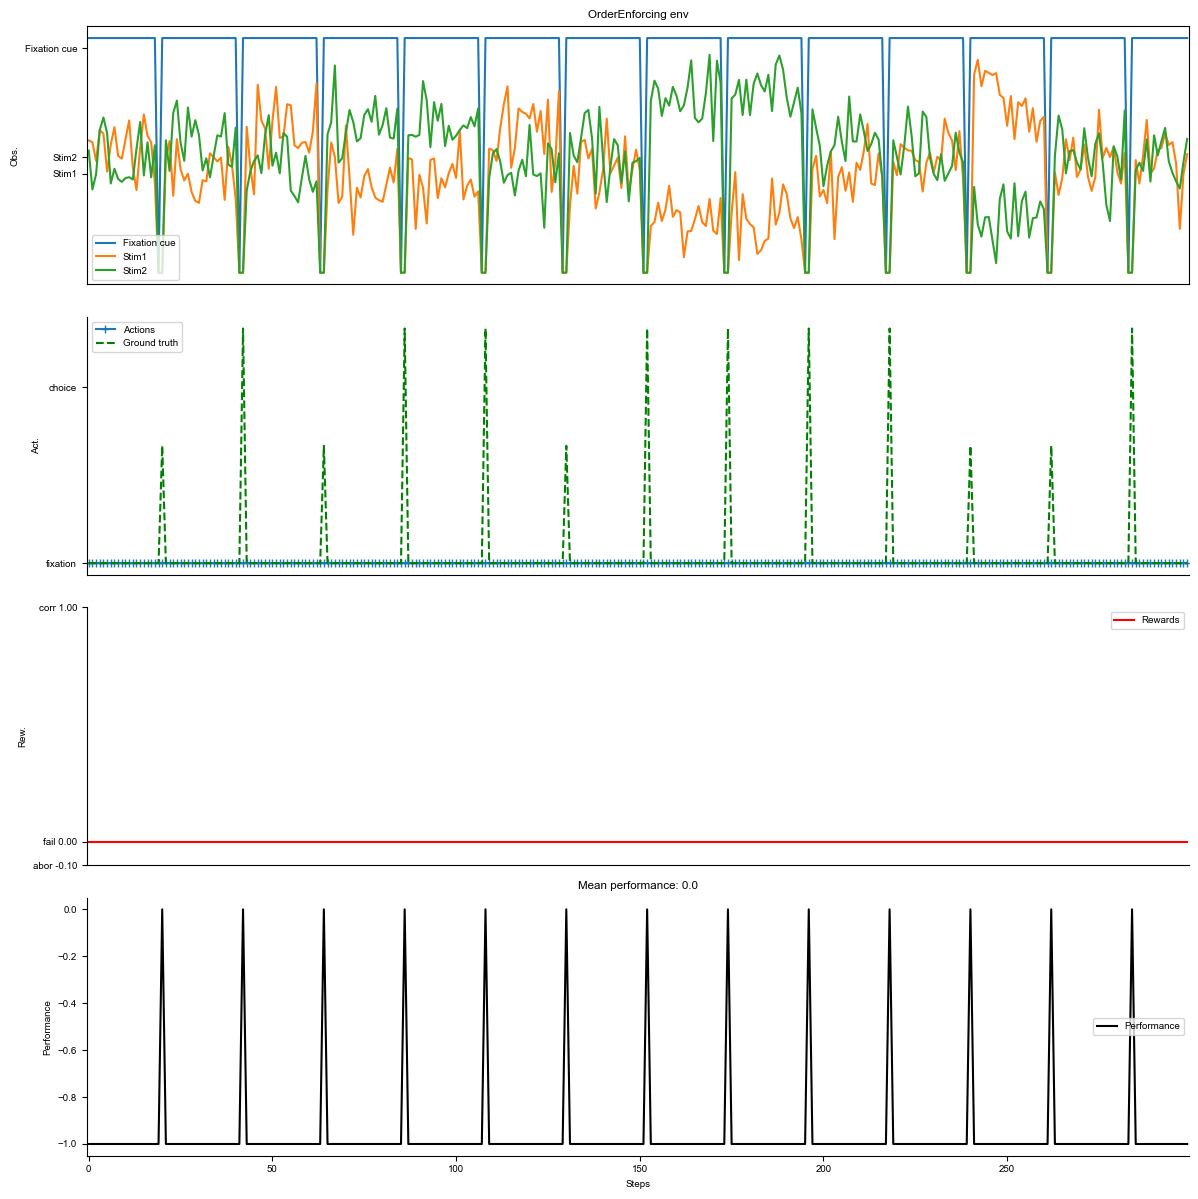

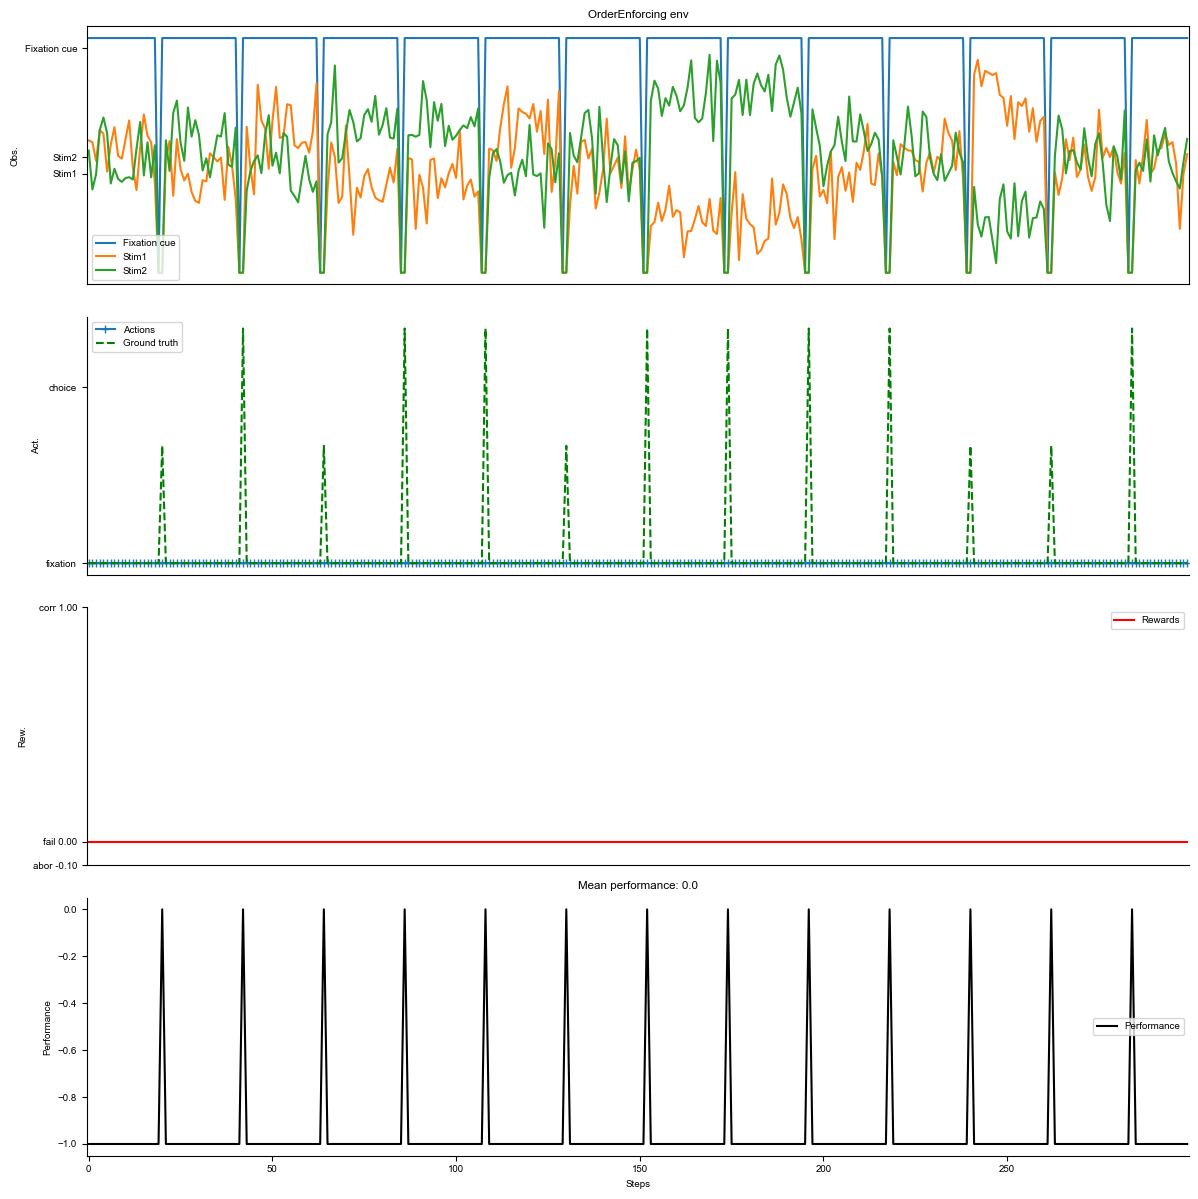

In [2]:
task = 'PerceptualDecisionMaking-v0'
env = gym.make(task)
print(env)
plotting.plot_env(env, num_steps=300, def_act=0, ob_traces=['Fixation cue', 'Stim1', 'Stim2'], fig_kwargs={'figsize': (12, 12)})

### Explore wrappers

In [3]:
info.all_wrappers()

Monitor-v0
Noise-v0
PassAction-v0
PassReward-v0
RandomGroundTruth-v0
ReactionTime-v0
ScheduleAttr-v0
ScheduleEnvs-v0
SideBias-v0
TrialHistoryV2-v0


In [4]:
info.info_wrapper('TrialHistoryV2-v0', show_code=True)

'### TrialHistoryV2-v0\n\nLogic: Missing description\n\n\n#### Source code #### \n\nclass TrialHistoryV2(TrialWrapper):\n    """Change ground truth probability based on previous outcome.\n\n    Args:\n        probs: matrix of probabilities of the current choice conditioned\n            on the previous. Shape, num-choices x num-choices\n    """\n\n    def __init__(self, env, probs=None):\n        super().__init__(env)\n        try:\n            self.n_ch = len(self.choices)  # max num of choices\n        except AttributeError:\n            raise AttributeError(\n                "TrialHistory requires task to " "have attribute choices"\n            )\n        if probs is None:\n            probs = np.ones((self.n_ch, self.n_ch)) / self.n_ch  # uniform\n        self.probs = probs\n        assert self.probs.shape == (self.n_ch, self.n_ch), (\n            "probs shape wrong, should be" + str((self.n_ch, self.n_ch))\n        )\n        self.prev_trial = self.rng.choice(self.n_ch)  # random i

### Train a network

In [5]:
# Original demo code updated to stable-baseline3
import warnings
import numpy as np
from neurogym.wrappers import trial_hist, monitor
from stable_baselines3.common.vec_env import DummyVecEnv
from stable_baselines3 import A2C  # ACER, PPO2
warnings.filterwarnings('default')
# task paremters
task = 'PerceptualDecisionMaking-v0'
timing = {'fixation': ('constant', 300),
          'stimulus': ('constant', 700),
          'decision': ('constant', 300)}
kwargs = {'dt': 100, 'timing': timing}
# wrapper parameters
n_ch = 2
p = 0.8
num_blocks = 2
block_1 = np.array([[p, 1-p], [1-p, p]])  # repeating block
block_2 = np.array([[1-p, p], [p, 1-p]])  # alternating block
probs = np.empty((num_blocks, n_ch, n_ch))
probs[0, :, :] = block_1
probs[1, :, :] = block_2

block_dur = 50

# build task
env = gym.make(task, **kwargs)
# Apply the wrapper
env = trial_hist.TrialHistory(env, probs=probs, block_dur=block_dur)
env = monitor.Monitor(env, folder='content/tests/', sv_per=10000, verbose=1, sv_fig=True, num_stps_sv_fig=100)
# the env is now wrapped automatically when passing it to the constructor
env = DummyVecEnv([lambda: env])
model = A2C("MlpPolicy", env, verbose=1, policy_kwargs={'net_arch': [64, 64]})
model.learn(total_timesteps=500000, log_interval=100000)
env.close()

ImportError: cannot import name 'trial_hist' from 'neurogym.wrappers' (/Users/giuliacrocioni/Desktop/docs/eScience/projects/ANNUBeS/neurogym/neurogym/wrappers/__init__.py)

In [11]:
# Code updated to TrialHistoryV2
import warnings
import numpy as np
from neurogym.wrappers import monitor, TrialHistoryV2
from stable_baselines3.common.vec_env import DummyVecEnv
from stable_baselines3 import A2C  # ACER, PPO2
warnings.filterwarnings('default')
# task paremters
task = 'PerceptualDecisionMaking-v0'
timing = {'fixation': ('constant', 300),
          'stimulus': ('constant', 700),
          'decision': ('constant', 300)}
kwargs = {'dt': 100, 'timing': timing}
# wrapper parameters
n_ch = 2
p = 0.8
num_blocks = 2
probs = np.array([[p, 1-p], [1-p, p]])  # repeating block

block_dur = 50

# build task
env = gym.make(task, **kwargs)
# Apply the wrapper
env = TrialHistoryV2(env, probs=probs)
env = monitor.Monitor(env, folder='content/tests/', sv_per=10000, verbose=1, sv_fig=True, num_stps_sv_fig=100)
# the env is now wrapped automatically when passing it to the constructor
env = DummyVecEnv([lambda: env])
model = A2C("MlpPolicy", env, verbose=1, policy_kwargs={'net_arch': [64, 64]})
model.learn(total_timesteps=500000, log_interval=100000)
env.close()

/Users/giuliacrocioni/miniforge3/envs/neurogym/lib/python3.10/site-packages/gymnasium/envs/registration.py:481: UserWarning: WARN: The environment creator metadata doesn't include `render_modes`, contains: ['paper_link', 'paper_name', 'tags']
  logger.warn(
/Users/giuliacrocioni/miniforge3/envs/neurogym/lib/python3.10/site-packages/gymnasium/core.py:311: UserWarning: WARN: env.choices to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.choices` for environment variables or `env.get_wrapper_attr('choices')` that will search the reminding wrappers.
  logger.warn(
/Users/giuliacrocioni/miniforge3/envs/neurogym/lib/python3.10/site-packages/gymnasium/core.py:311: UserWarning: WARN: env.rng to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.rng` for environment variables or `env.get_wrapper_attr('rng')` that will search the reminding wrappers.

Using cpu device
--------------------
Number of steps:  10000.0
Average reward:  0.4983
--------------------
--------------------
Number of steps:  20000.0
Average reward:  0.5146
--------------------
--------------------
Number of steps:  30000.0
Average reward:  0.508
--------------------
--------------------
Number of steps:  40000.0
Average reward:  0.5058
--------------------
------------------------------------
| time/                 |          |
|    fps                | 2003     |
|    iterations         | 100000   |
|    time_elapsed       | 249      |
|    total_timesteps    | 500000   |
| train/                |          |
|    entropy_loss       | -0.00374 |
|    explained_variance | 0.135    |
|    learning_rate      | 0.0007   |
|    n_updates          | 99999    |
|    policy_loss        | 0.00041  |
|    value_loss         | 0.587    |
------------------------------------


### Visualize results

In [7]:
# Original demo code updated to stable-baseline3
import numpy as np
import matplotlib.pyplot as plt
# Create task
env = gym.make(task, **kwargs)
# Apply the wrapper
env = trial_hist.TrialHistory(env, probs=probs, block_dur=block_dur)
env = DummyVecEnv([lambda: env])
plotting.plot_env(env, num_steps=50, def_act=0, ob_traces=['Fixation cue', 'Stim1', 'Stim2'], fig_kwargs={'figsize': (12, 12)}, model=model);

/Users/giuliacrocioni/miniforge3/envs/neurogym/lib/python3.10/site-packages/gymnasium/envs/registration.py:481: UserWarning: WARN: The environment creator metadata doesn't include `render_modes`, contains: ['paper_link', 'paper_name', 'tags']
  logger.warn(


NameError: name 'trial_hist' is not defined

/Users/giuliacrocioni/miniforge3/envs/neurogym/lib/python3.10/site-packages/gymnasium/envs/registration.py:481: UserWarning: WARN: The environment creator metadata doesn't include `render_modes`, contains: ['paper_link', 'paper_name', 'tags']
  logger.warn(
/Users/giuliacrocioni/miniforge3/envs/neurogym/lib/python3.10/site-packages/gymnasium/core.py:311: UserWarning: WARN: env.choices to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.choices` for environment variables or `env.get_wrapper_attr('choices')` that will search the reminding wrappers.
  logger.warn(
/Users/giuliacrocioni/miniforge3/envs/neurogym/lib/python3.10/site-packages/gymnasium/core.py:311: UserWarning: WARN: env.rng to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.rng` for environment variables or `env.get_wrapper_attr('rng')` that will search the reminding wrappers.

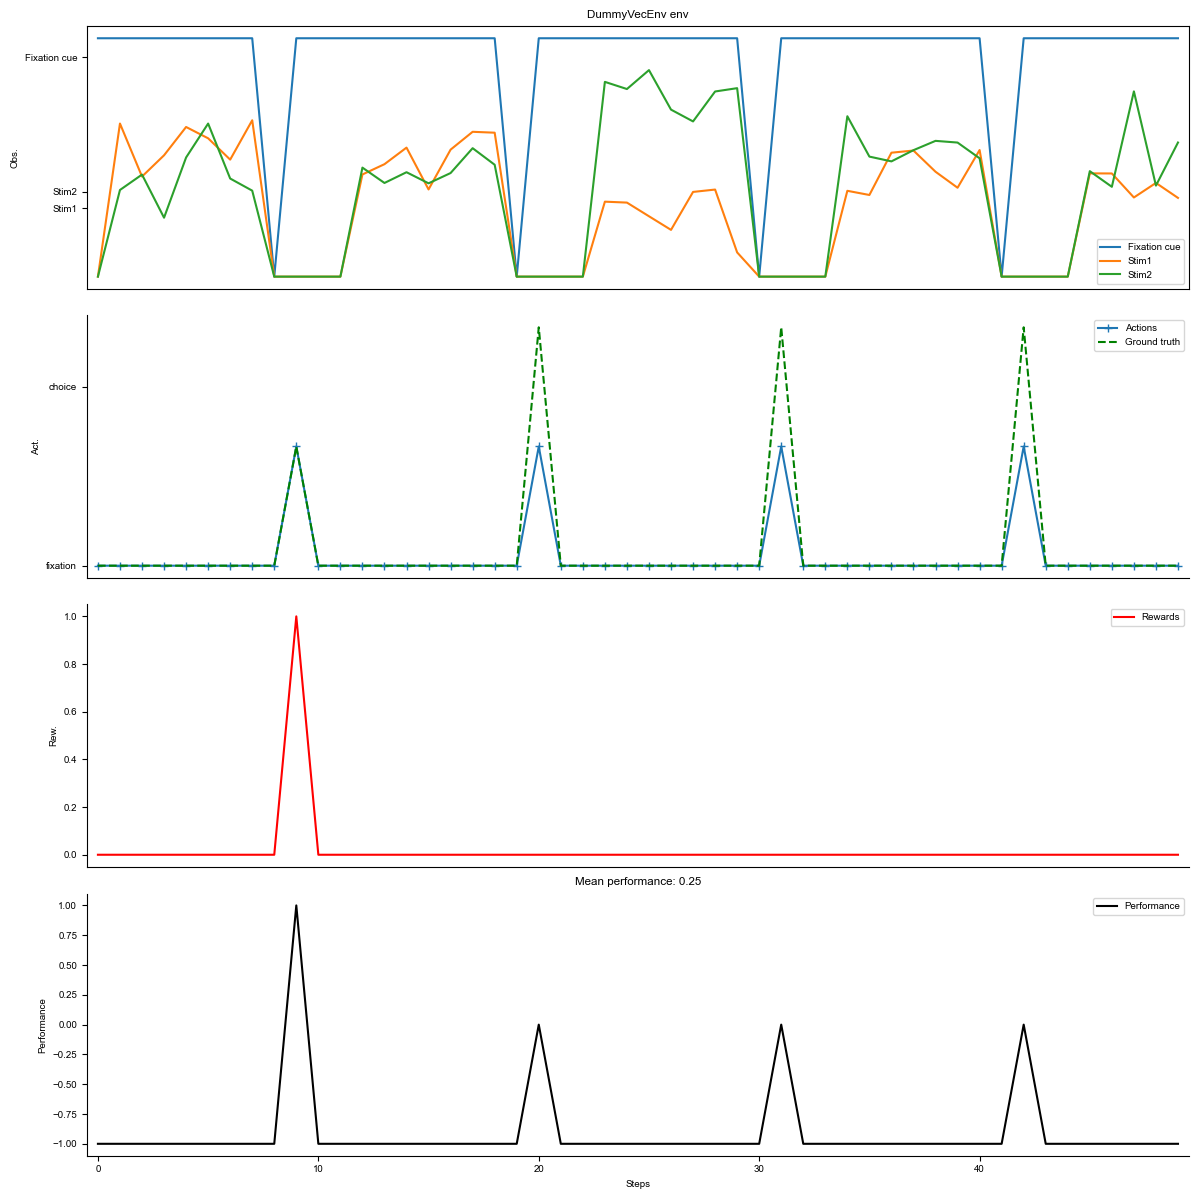

In [10]:
# Code updated to TrialHistoryV2
import numpy as np
import matplotlib.pyplot as plt
# Create task
env = gym.make(task, **kwargs)
# Apply the wrapper
env = TrialHistoryV2(env, probs=probs)
env = DummyVecEnv([lambda: env])
plotting.plot_env(env, num_steps=50, def_act=0, ob_traces=['Fixation cue', 'Stim1', 'Stim2'], fig_kwargs={'figsize': (12, 12)}, model=model);